<a href="https://colab.research.google.com/github/eshowalterloch/BigDataPhysics/blob/main/GW_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 1**


In [ ]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 25.7 MB/s eta 0:00:00
    

In [ ]:
from pycbc.frame import read_frame
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from pycbc.catalog import Merger
import pylab
from pycbc.types import  FrequencySeries, TimeSeries

from scipy import interpolate

import numpy as np
from pycbc import frame
import pycbc
from pycbc.filter import resample_to_delta_t, highpass
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.stats import norm 
from pycbc.detector import Detector
from scipy.interpolate import interp1d

import lal
import lalsimulation

from scipy import interpolate
from numpy import pi
from scipy import constants
from pycbc.conversions import *
from astropy import cosmology
from pycbc import waveform

import pylab
from pycbc.waveform import get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants

Load the data and downsample it

In [ ]:
import pylab
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

d = np.load('GW_noisedata-2.npy') #name of the data file noise_ts_4096Hz.npy
dt = d[:, 0]
data_H1 = pycbc.types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
data_L1 = pycbc.types.TimeSeries(d[:, 2], delta_t = dt[1]- dt[0]) #this is to comvert data into GW timeSeries
#merger = Merger("GW170817")
strain, stilde = {}, {}
strain['H1'] = resample_to_delta_t(highpass(data_H1, 15.0), 1.0/2048)
strain['L1'] = resample_to_delta_t(highpass(data_L1, 15.0), 1.0/2048)

strain['H1'] = strain['H1'].crop(4, 4)
strain['L1'] = strain['L1'].crop(4, 4)

stilde['H1'] = strain['H1'].to_frequencyseries()
stilde['L1'] = strain['L1'].to_frequencyseries()



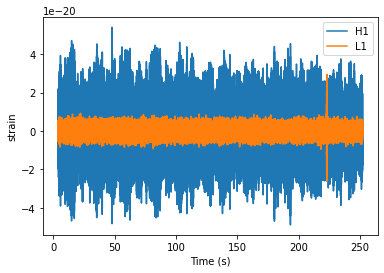

In [ ]:
#print (strain.delta_t)
pylab.plot(strain['H1'].sample_times, strain['H1'], label= 'H1')
pylab.plot(strain['L1'].sample_times, strain['L1'], label= 'L1')
pylab.legend()
pylab.xlabel('Time (s)')
pylab.ylabel('strain')
pylab.show()

The delta_f for the power spectral density data is:


0.004032258064516129

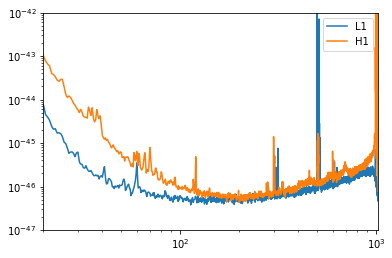

In [ ]:
#first plot the power spectral density of the data
#it is important to whiten the data or in order to find the SNR
import pycbc.psd
from pycbc.psd import interpolate

psds = {}
for ifo in ['L1', 'H1']:


    delta_t = strain[ifo].delta_t   #Calls the sampling rate
    seg_len = int(2 / delta_t)   #Define the segment length, because it cuts the signal into smaller chunks (Can change the 2 to a 3, 4, 5 etc based on how good the graph below is looking)
    seg_stride = int(seg_len / 2)   
    psds[ifo]  = pycbc.psd.welch(strain[ifo],  
                      seg_len=seg_len,
                      seg_stride=seg_stride)
    
    psds[ifo] = interpolate(psds[ifo], stilde[ifo].delta_f)  

    pylab.loglog(psds[ifo].sample_frequencies, psds[ifo], label=ifo)   
    pylab.xlim(20, 1024)
    pylab.ylim(1e-47, 1e-42)
pylab.legend()


print('The delta_f for the power spectral density data is:')
psds[ifo].delta_f

Plot SNR over mass, to fine the masses of the system

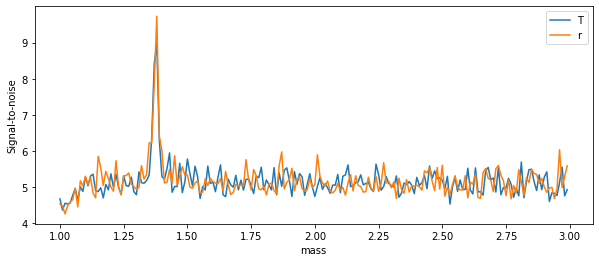

In [ ]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower


mass1 = np.arange(1, 3, 0.01) #mass range bewteen 30 to 40 Solar mass, this is an assumption, can change the range if you want
mass2 = mass1  #also assuming our masses are the same size

# Variables to store when we've found the max
hmax, smax, tmax, mmax, nsnr = None, {}, {}, 0, 0  
snrs = {}
ifo = 'H1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=20.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)  #This is the K(t) 
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=15.0)  #Change this based on when you are starting your waveform from 

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)  


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list



ifo = 'L1'
Snr_list = []
for i in range(len(mass1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
 
    m = mass1[i] # Solar masses
    hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=strain[ifo].delta_t,
                     f_lower=20.0)

    # We will resize the vector to match our data
    hp.resize(len(strain[ifo]))
    template = hp.cyclic_time_shift(hp.start_time)
    
    snr = matched_filter(template, strain[ifo],
                     psd=psds[ifo], low_frequency_cutoff=20.0)

    # Remove time corrupted by the template filter and the psd filter
    # We remove 4 seonds at the beginning and end for the PSD filtering
    # And we remove 4 additional seconds at the beginning to account for
    # the template length (this is somewhat generous for 
    # so short a template). A longer signal such as from a BNS, would 
    # require much more padding at the beginning of the vector.
    snr_H1 = snr.crop(4 + 4, 4)


    Snr_list.append(max(abs(snr_H1)))
snrs[ifo] = Snr_list

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, snrs['H1'], label= 'H1')
pylab.plot(mass1, snrs['L1'], label= 'L1')
pylab.legend('True')
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

Combine SNRs from both detectors

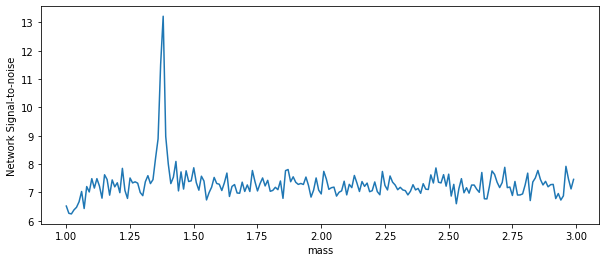

We found the best Mass1=Mass2 was 1.38 solar masses (detector frame)


In [ ]:
nsnr = (np.array(snrs['H1'])**2 + np.array(snrs['L1'])**2)**0.5  #Network snr, a combination of the snr from both detectors
ii = np.where(nsnr == max(nsnr))  #Find the maximum value, or the best answer for the probable mass of each object
pylab.figure(figsize=[10, 4])
pylab.plot(mass1, nsnr)

pylab.ylabel('Network Signal-to-noise')
pylab.xlabel('mass')
pylab.show()

print("We found the best Mass1=Mass2 was %2.2f solar masses (detector frame)" % mass1[ii])

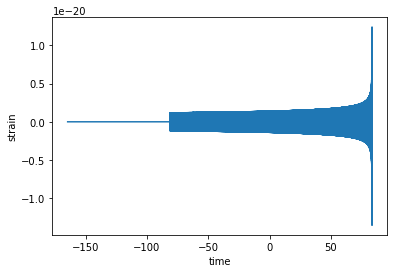

In [ ]:
m = 1.38 # Solar masses, found from the module up above
conditioned = strain['H1']
hp, hc = get_td_waveform(approximant="TaylorT2",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20.0)

# We will resize the vector to match our data
hp.resize(len(conditioned))

template = hp.cyclic_time_shift(hp.start_time)
pylab.plot(hp.sample_times, template)
pylab.xlabel('time')
pylab.ylabel('strain')
pylab.show()

Plot SNR over time and find the max SNR

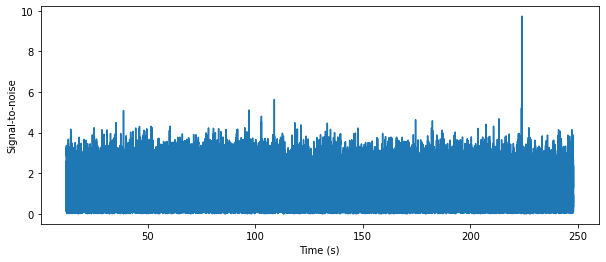

We found a signal at 224.02490234375s with SNR 9.725701597406237


In [ ]:
from pycbc.filter import matched_filter
import numpy

ifo = 'L1'                            
conditioned = strain[ifo]
snr = matched_filter(template, conditioned,
                     psd=psds[ifo] , low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why am I taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()  #Find where the sharp peak is, and what the SNR is for that time, which indicates a possible signal bc the SNR is so high
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

Fit the best match template to the data

In [ ]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time 
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)  

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psds[ifo], low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

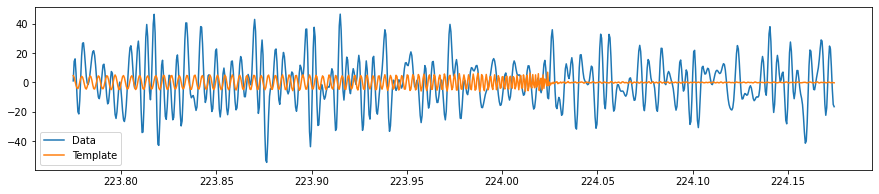

In [ ]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

# apply a smoothing of the turnon of the template to avoid a transient
# from the sharp turn on in the waveform.
tapered = aligned.highpass_fir(30, 512, remove_corrupted=False)
white_template = (tapered.to_frequencyseries() / psds[ifo]**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
#white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(snr.sample_times[peak]-.25, snr.sample_times[peak]+.15)
white_template = white_template.time_slice(snr.sample_times[peak]-.25, snr.sample_times[peak]+.15)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.legend()
pylab.show()

Show chirp structure using Q-transform

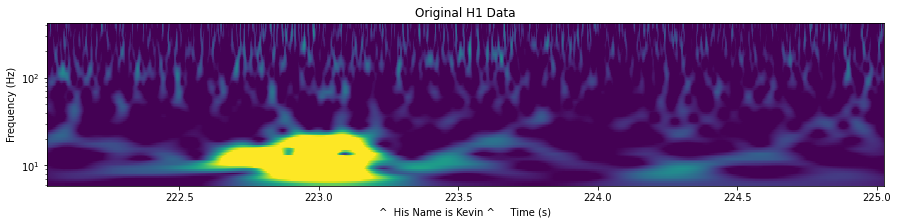

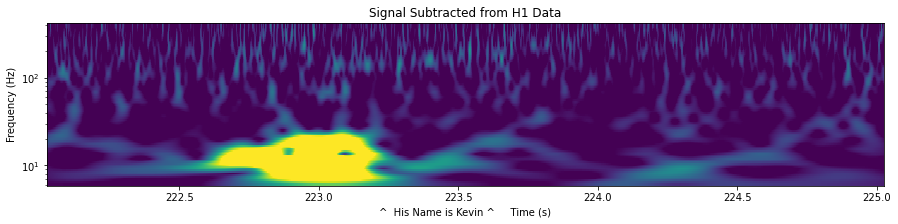

In [ ]:
subtracted = conditioned - aligned

# Plot the original data and the subtracted signal data

for data, title in [(conditioned, 'Original H1 Data'),
                    (subtracted, 'Signal Subtracted from H1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                                  logfsteps=100,
                                                  qrange=(8, 8),
                                                  frange=(6, 412))  #Q transform is the same as spectrogram, but it outputs the data for the graph below
    pylab.figure(figsize=[15, 3])
    pylab.title(title)
    pylab.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
    pylab.yscale('log')
    pylab.xlabel('^  His Name is Kevin ^     Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.xlim(snr.sample_times[peak] - 2, snr.sample_times[peak] + 1)
    pylab.show()

Check for correct match of solar masses

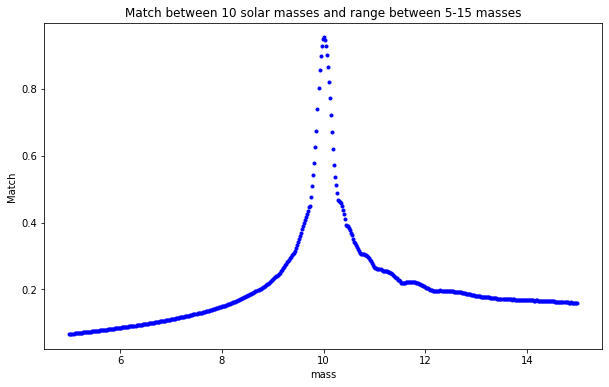

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower

f_low = 30
sample_rate = 4096 

masses = np.arange(5,15,0.02)
matchesResult = {}

for mass in masses:
# Generate the two waveforms to compare 
    hp, hc = get_td_waveform (approximant="EOBNRv2",
                         mass1=10, 
                         mass2=10, 
                         f_lower=f_low,
                         delta_t=1.0/sample_rate) 




    sp, sc=get_td_waveform (approximant="TaylorT4", 
                         mass1=mass, 
                         mass2=mass, 
                         f_lower=f_low, 
                         delta_t=1.0/sample_rate) 
 
# Resize the waveforms to the same length 
    tlen = max(len(sp),len(hp))
    sp.resize(tlen)
    hp.resize(tlen)

# Generate the aLIGO ZDHP PSD 
    delta_f = 1.0 / sp.duration
    flen = tlen//2 +1 
    psd = aLIGOZeroDetHighPower(flen, delta_f, f_low) 
 
# Note: This takes a while the first time as an FFT plan is generated 
# subsequent calls are much faster. 
    m, i = match(hp, sp, psd=psd, low_frequency_cutoff = f_low) 

    matchesResult[mass] = m

pylab.figure(figsize=[10, 6])
pylab.title("Match between 10 solar masses and range between 5-15 masses")
pylab.ylabel('Match')
pylab.xlabel('mass')
pylab.plot(*zip(*matchesResult.items()),'b.')
pylab.show()


In [ ]:
#This is the end of Question 1
#
#
#
#
#
#
#
#
#


# **Question 2**



Plot the Noise PSD

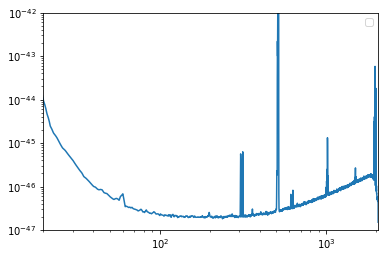

In [ ]:
import pycbc.types
from pycbc.psd import inverse_spectrum_truncation

d2 = np.load('noise_ts_4096Hz.npy') #Load the new data file with the name noise_ts_4096Hz.npy
dt=d2[:,0]
data = pycbc.types.TimeSeries(d2[:, 1], delta_t = dt[1]- dt[0]) #Converting the data into time series data

psds = interpolate(welch(data), 1/data.duration)

pylab.loglog(psds.sample_frequencies, psds)   
pylab.xlim(20, max(psds.sample_frequencies))
pylab.ylim(1e-47, 1e-42)
pylab.legend()

Test for a gravitational wave signal

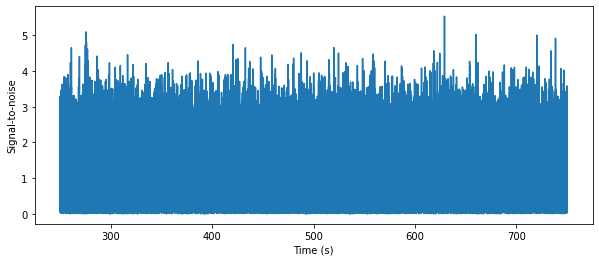

We did not find a signal because the maximum SNR at 629.03466796875s has a value of 5.532321366727709.
This is lower than the threshold for GW, which is an SNR of 8 or higher


In [ ]:
stilde = data.to_frequencyseries()
masses = np.arange(5,10,0.05)

for m in masses:
    hp, hc = get_fd_waveform(approximant="TaylorF2",
                            mass1=m,
                            mass2=m,
                            delta_f=stilde.delta_f,
                            f_lower=20)
    
    hp.resize(len(stilde))
  # Creating the template from get_fd_waveform above
    template = hp.cyclic_time_shift(hp.start_time)
  # Find the SNR between the data and template
    snr = matched_filter(template, stilde,
                          psd=psds, 
                          low_frequency_cutoff=20)
    snr = snr[len(snr) // 4: len(snr) * 3 // 4]

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()  #Find where the sharp peak is, and what the SNR is for that time, which indicates a possible signal bc the SNR is so high
snrp = snr[peak]
time = snr.sample_times[peak]

print("We did not find a signal because the maximum SNR at {}s has a value of {}.".format(time, abs(snrp)))
print("This is lower than the threshold for GW, which is an SNR of 8 or higher")


Whiten the data and show it has gaussian distribution

Mu is:0.0014166022882674619. Sigma is:44.72975447257879.


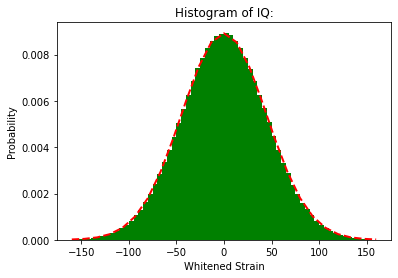

In [ ]:
delta_t = 1.0/4096
seg_len = int(2 / delta_t)
seg_stride = int(seg_len / 2)   

psds = pycbc.psd.welch(data,  
                      seg_len=seg_len,
                      seg_stride=seg_stride)

psd = interpolate(welch(data), 1/data.duration)

# We do it this way so that we can whiten both the template and the data 
white_data = (stilde / psd**0.5).to_timeseries()

#Don't forget to crop the data
white_datacrop = white_data.crop(4,4)

plt.hist(white_datacrop, (range(-160,160,5)), color = "green", density=True)
(mu, sigma) = norm.fit(white_datacrop)
seq = np.linspace(-160,160,25)
plt.plot(seq, norm.pdf(seq, mu, sigma), linewidth = 2, color = "red", ls="--")
plt.title("Histogram of IQ:")
plt.xlabel("Whitened Strain")
plt.ylabel("Probability")
print("Mu is:"+str(mu)+". Sigma is:"+str(sigma)+".")

Test if the gaussian is stationary or not

In [ ]:
from pycbc.filter import sigmasq

#Generate frequency domain waveform
hp, hc = get_fd_waveform(approximant="TaylorF2",   
                         mass1=3,                  
                         mass2=3,   
                         delta_f = 1.0/(200),                  
                         distance = 500,           #Luminosity distance = 500 Mpc
                         f_lower=20.0, f_final = 2048.0)

#Estimate the psd from data chunks
chunk = 1000
data_chunks = int(len(data/chunk))  #1000 for the maximum number of chunks
print(da)
#initiate a for loop over the chunks and plot the psd of each chunk
snrlist = []
for n in range(chunk):
    data_chunk = data[n*data_chunks : (n+1)*data_chunks]
    psds = pycbc.psd.interpolate(pycbc.psd.welch(data_chunk), hp.delta_f)  #estimate psd for that chunk
    snr_optimal= (pycbc.filter.sigmasq(hp, psds))**0.5
    snrlist.append(snr_optimal)  #create snr list after calculating optimal snr from above


from statistics import mean, stdev
#extract mu and sigma from the list of snr
mu, sigma = mean(snrlist), stdev(snrlist)

#Plot the data
plt.hist(snrlist, 100, density = True, color = 'green')
plt.title('Check for a stationary Gaussian; Mean: {:.5f}, Standard Dev: {:.5f}'.format(mu, sigma))
plt.xlim(10,25)
plt.show()